In [2]:
from os.path import expanduser, join

import numpy as np
from sklearn import utils

import matplotlib.pyplot as plt

from skimage.feature import peak_local_max

from localizer import config, util, visualization, models, keras_helpers

%matplotlib inline
#%matplotlib notebook

import seaborn as sns
sns.set(color_codes=True)

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, CuDNN 4007)


In [199]:
import importlib
for module in (config, util, visualization, models, keras_helpers):
    importlib.reload(module)

In [4]:
data_dir = join(expanduser("~"), 'deeplocalizer_data', 'data_mxnet2')

In [5]:
X_train, y_train, X_test, y_test, X_val, y_val = util.load_or_restore_data(data_dir)

Restoring mmapped data


/usr/lib/python3.5/site-packages/numpy/core/memmap.py:263: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  offset=offset, order=order)


In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(164529, 1, 100, 100)
(18725, 1, 100, 100)
(18725, 1, 100, 100)


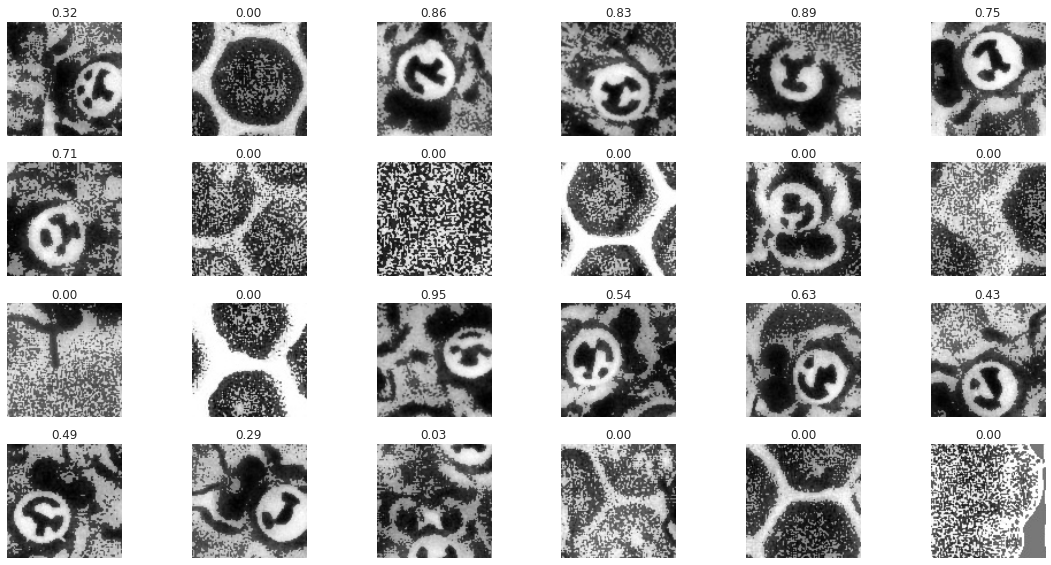

In [7]:
fig = visualization.plot_sample_images(X_train, y_train, random=True)

In [8]:
Xs_train = util.resize_data(X_train, config.filtersize)
Xs_val   = util.resize_data(X_val, config.filtersize)
Xs_test  = util.resize_data(X_test, config.filtersize)

print(Xs_train.shape)
print(Xs_test.shape)
print(Xs_val.shape)

19456/18725 [===============================] - 9s    
(164529, 1, 32, 32)
(18725, 1, 32, 32)
(18725, 1, 32, 32)


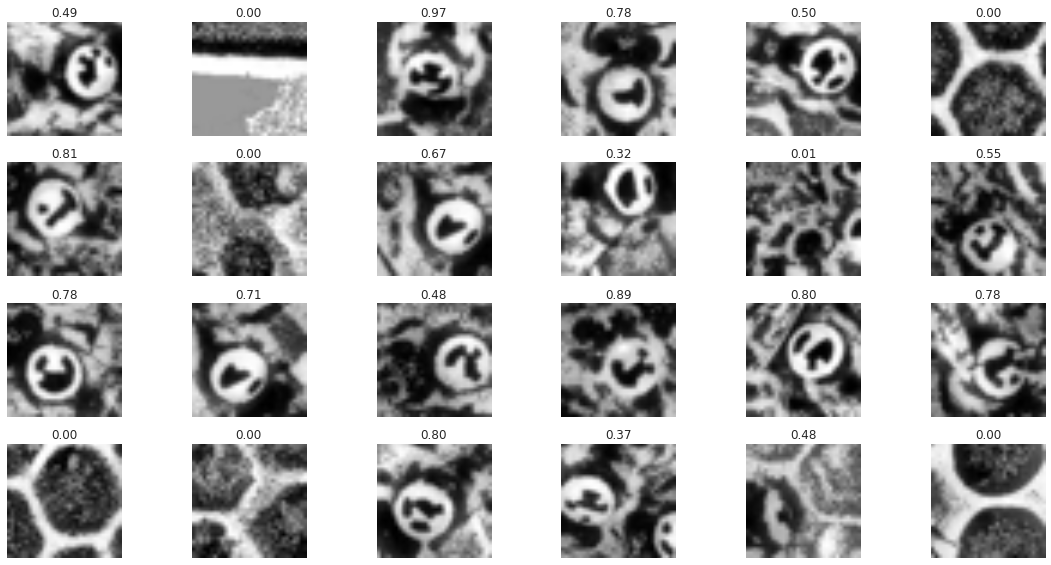

In [9]:
fig = visualization.plot_sample_images(Xs_train, y_train)

In [36]:
saliency_network = models.get_saliency_network(train=True, compile=False)

In [37]:
saliency_datagen = keras_helpers.get_datagen(Xs_train)
saliency_class_weight = [1., 1.]
saliency_weight_file = join(expanduser("~"), 'saliency-localizer-models', 'season_2015', 'saliency_weights-wobn')

In [38]:
saliency_history = keras_helpers.fit_model(saliency_network, saliency_datagen, Xs_train, y_train, Xs_val, y_val,
                                           saliency_weight_file, saliency_class_weight, batchsize=128, categorial=False)

Epoch 0
18944/18853 [==============================] - 3s - test loss: 0.0153     

0 epochs since last improvement

Epoch 1
18944/18853 [==============================] - 3s - test loss: 0.0119     

0 epochs since last improvement

Epoch 2
18944/18853 [==============================] - 3s - test loss: 0.0104     

0 epochs since last improvement

Epoch 3
18944/18853 [==============================] - 3s - test loss: 0.0097     

0 epochs since last improvement

Epoch 4
18944/18853 [==============================] - 3s - test loss: 0.0088     

0 epochs since last improvement

Epoch 5
18944/18853 [==============================] - 3s - test loss: 0.0083     

0 epochs since last improvement

Epoch 6
18944/18853 [==============================] - 3s - test loss: 0.0081     

0 epochs since last improvement

Epoch 7
18944/18853 [==============================] - 3s - test loss: 0.0080     

0 epochs since last improvement

Epoch 8
18944/18853 [==============================] - 3s - test

In [39]:
batch_error = np.array([hist[0] for hist in saliency_history.batch_hist])

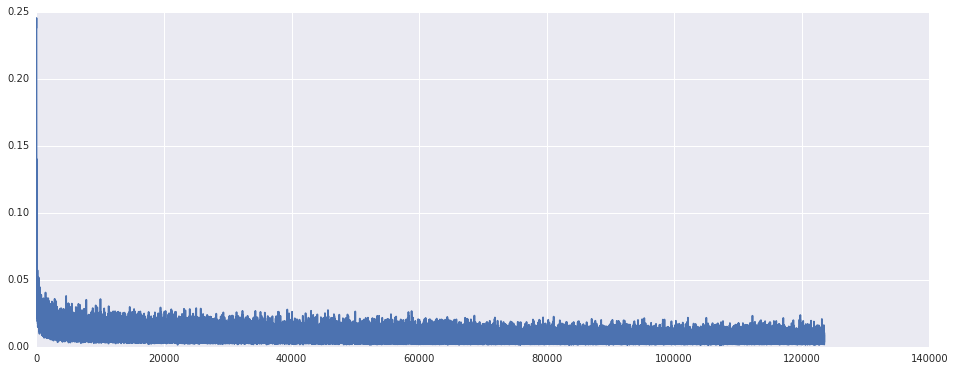

In [40]:
plt.figure(figsize=(16, 6))
_ = plt.plot(batch_error)

In [41]:
batch_error.shape[0] / (658145 / 256)

48.05827287299911

In [42]:
batch_error[-1]

0.0035345587

In [43]:
saliency_network.load_weights(saliency_weight_file)

In [52]:
ys_out = keras_helpers.predict_model(saliency_network, Xs_test, saliency_datagen)

18944/18981 [============================>.] - ETA: 0s

In [55]:
max(ys_out[:, 1])

0.99909210205078125

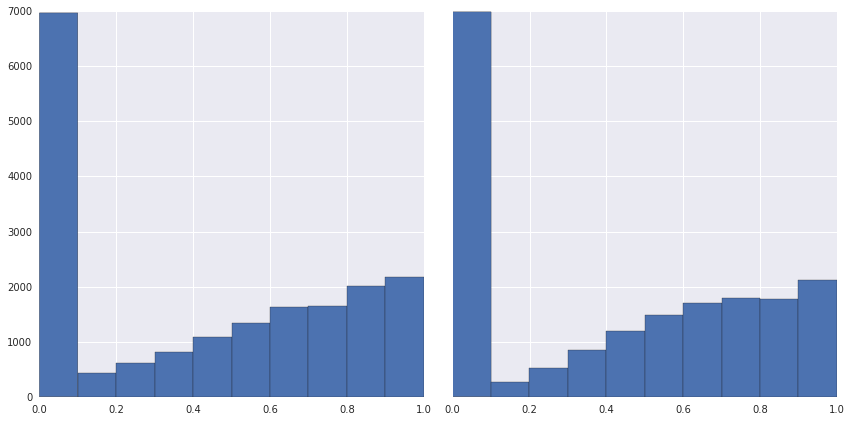

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 6))
axes.flat[0].hist(y_test[:])
axes.flat[1].hist(ys_out[:, 1])

plt.tight_layout()

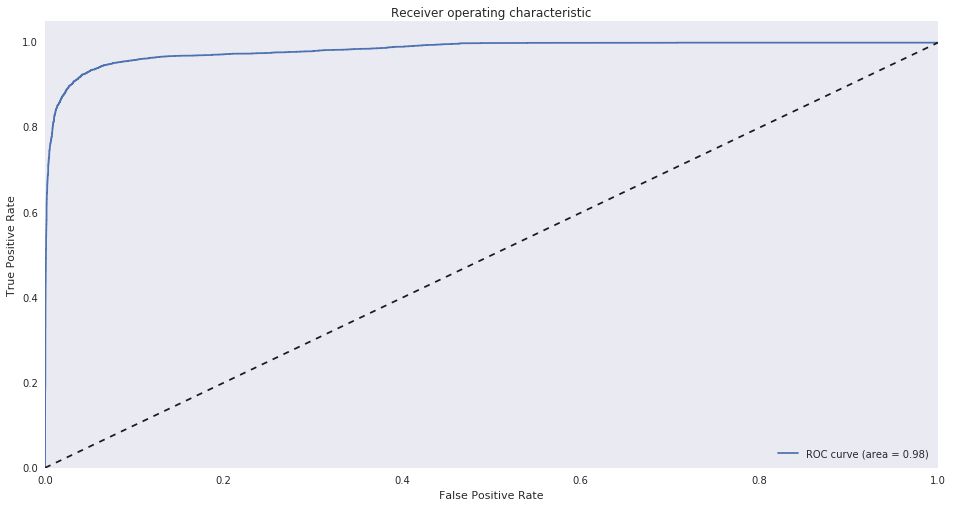

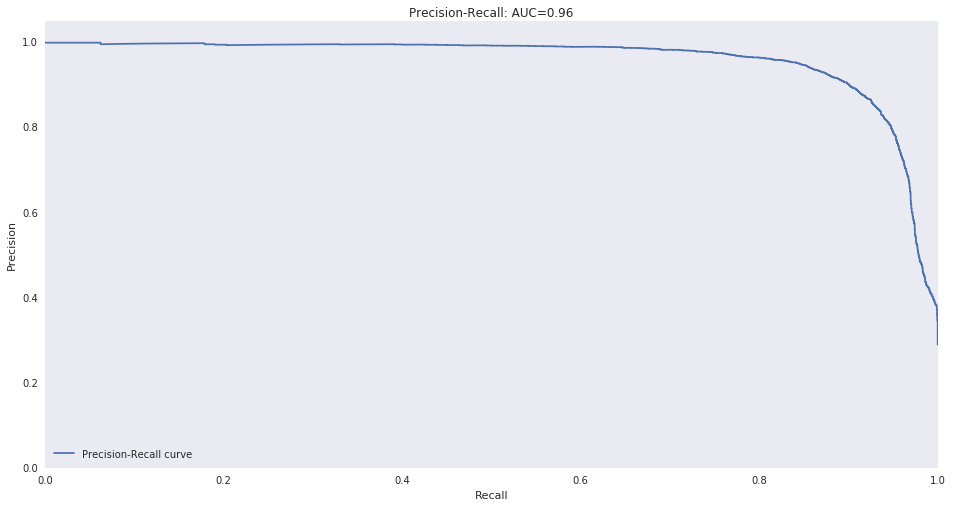

In [57]:
precision, recall, average_precision, thresholds, fpr, tpr, roc_auc = keras_helpers.evaluate_model(
    y_test > 0.8, ys_out, visualize=True)

In [58]:
saliency_threshold = keras_helpers.select_threshold(precision, recall, thresholds, min_value=0.98, optimize='recall')

('Recall', 0.98021454112038142)
('Precision', 0.48490566037735849)
('Threshold', 0.52992475032806396)
('F_2', 0.81393507521773556)
('F_0.5', 0.53942017578381218)


In [59]:
saliency_threshold = 0.5

In [150]:
convolution_container = models.get_saliency_network(train=False, shape=image_filtersize.shape)

In [151]:
convolution_function = keras_helpers.get_convolution_function(saliency_network, convolution_container)

In [152]:
image_path = join(expanduser("~"), 'deeplocalizer_data')
with open(join(image_path, 'test.txt'), 'r') as f:
    image_files = [line.split('\n')[0] for line in f.readlines()]

In [153]:
imfile = image_files[0]
image, image_filtersize, targetsize = util.preprocess_image(join(image_path, imfile), config.filtersize)

In [156]:
%%%timeit
convolution_function(image_filtersize.reshape((1, 1, image_filtersize.shape[0], image_filtersize.shape[1])))

The slowest run took 8.14 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 48.1 ms per loop


In [212]:
saliency = convolution_function(image_filtersize.reshape((1, 1, image_filtersize.shape[0], image_filtersize.shape[1])))[0]

In [213]:
saliency.shape

(1, 1, 952, 1272)

In [214]:
saliency = gaussian_filter(saliency[0, 0], sigma=3.)

/usr/lib/python3.5/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


In [ ]:
    def get_saliency_image(self, image_fname):
        image, image_filtersize, targetsize = util.preprocess_image(
                    image_fname, config.filtersize)
        saliency = self.convolution_function(
            image_filtersize.reshape((1, 1, image_filtersize.shape[0],
                                      image_filtersize.shape[1])))
        saliency = gaussian_filter(saliency[0, 0], sigma=3.)
        return saliency, image

    def detect_tags(self, image_path, saliency_threshold=0.5):
        saliency, image = self.get_saliency_image(image_path)
        candidates = util.get_candidates(saliency, saliency_threshold)
        saliencies = util.extract_saliencies(candidates, saliency)
        candidates_img = util.scale_candidates(candidates, saliency)
        rois, mask = util.extract_rois(candidates_img, image)
        return saliencies[mask], candidates_img, rois

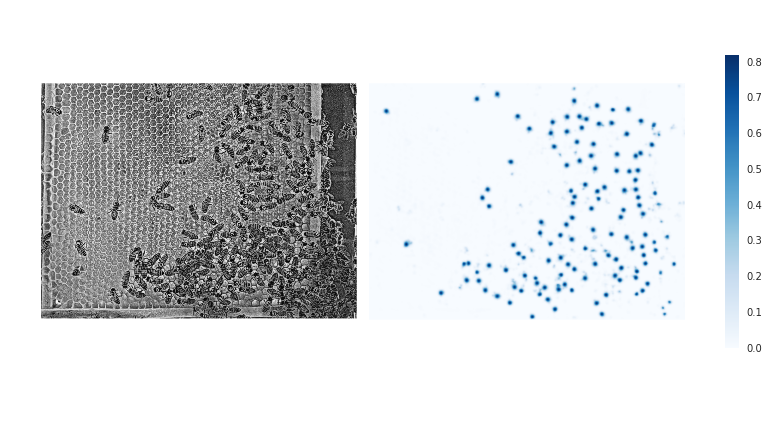

In [216]:
_ = visualization.plot_saliency_image(image_filtersize, saliency, config.filtersize, figsize=(12, 6))

#plt.savefig('saliency.png', dpi=300, bbox_inches='tight')

In [217]:
candidates = util.get_candidates(saliency, saliency_threshold, dist=config.filtersize[0] // 4)

In [218]:
saliencies = util.extract_saliencies(candidates, saliency)

In [219]:
candidates_img = util.scale_candidates(candidates, saliency)

/usr/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [220]:
rois, mask = util.extract_rois(candidates_img, image)

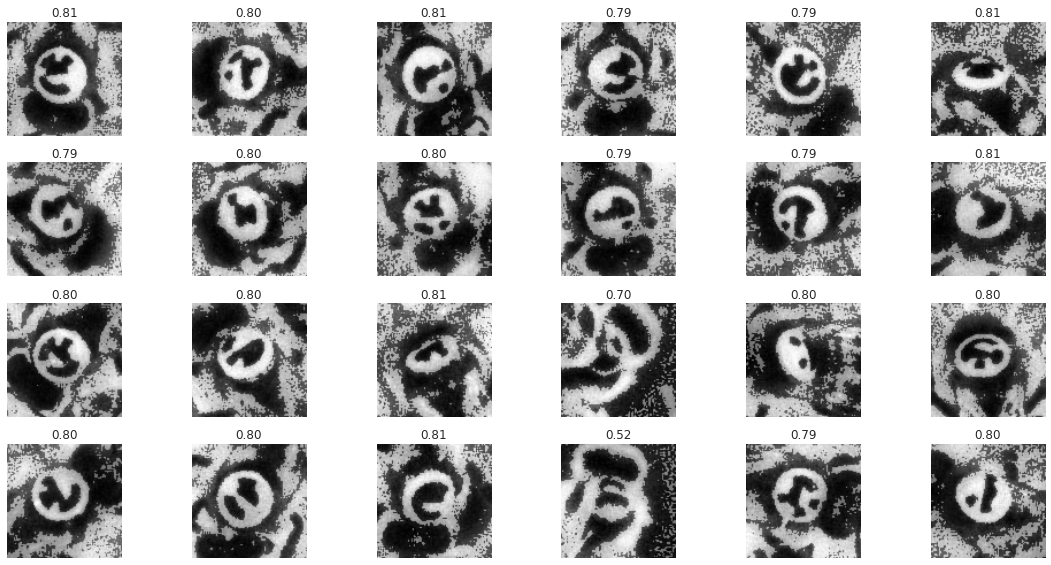

In [221]:
fig = visualization.plot_sample_images(rois, saliencies)

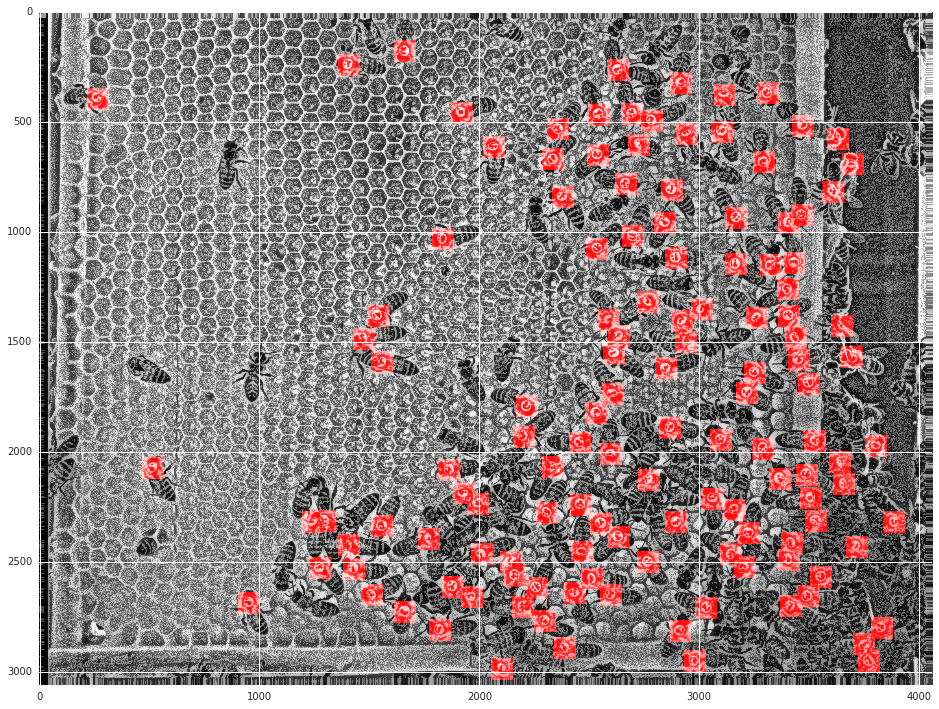

In [224]:
plt.figure(figsize=(16, 16))
_ = plt.imshow(visualization.get_roi_overlay(candidates_img, image))